# Исследование рекламных источников для игры

**Описание**

Заказчик - команда мобильной игры. Основная монетизация игры планируется на втором уровне. Предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки. 

Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

**Цель проекта:**

Проанализировать поведение игроков в зависимости от источника перехода.

**Описание данных**

В основном датасете содержатся данные по игре пользователей на первом уровне — когорты игроков, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет *game_actions.csv*:

- `event_datetime` - время события;
- `event` - одно из трёх событий:
    1. `building` - объект построен,
    2. `finished_stage_1` - первый уровень завершён,
    3. `project` - проект завершён;
    
    
- `building_type` - один из трёх типов здания:
    1. `assembly_shop` - сборочный цех,
    2. `spaceport` - космопорт,
    3. `research_center` - исследовательский центр;
    
    
- `user_id` - идентификатор пользователя;
- `project_type` - тип реализованного проекта;


Помимо основного датасета есть два дополнительных с информацией о рекламных активностях.

Датасет *ad_cost.csv*:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет *user_source.csv*:

- `user_id` - идентификатор пользователя
- `source` - источник, с которого пришёл пользователь, установивший приложение


**Ход исследования**

1. Обзор и предобработка данных.   

2. Исследовательский анализ данных.
 
3. Оценка эффективности рекламных источников.
 
4. Статистический анализ данных.
 
5. Общий вывод по результатам исследования.

**Импорт библиотек**

В первую очередь импортируем все необходимые для исследования библиотеки:

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import stats as st

## Обзор и предобработка данных

Сохраним таблицы в переменные.

In [2]:
actions = pd.read_csv('/datasets/game_actions.csv')
sources = pd.read_csv('/datasets/user_source.csv')
costs = pd.read_csv('/datasets/ad_costs.csv')

Посмотрим общую информацию о датасетах и выведем первые строки таблиц.

In [3]:
display(actions.head(3), sources.head(3), costs.head(3)) # вывод первых строк таблиц

print() # вывод информации о таблицах
actions.info()
print()
sources.info()
print()
costs.info()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-n

Столбец `event_datetime` в таблице `actions` и столбец `day` в таблице `costs` нужно привести к формату даты/времени.

In [4]:
actions['event_datetime'] = pd.to_datetime(actions['event_datetime'])
costs['day'] = pd.to_datetime(costs['day']) # изменение типа данных

В столбцах таблицы `actions` есть пропуски, посчитаем их.

In [5]:
actions.isnull().sum() # подсчет пропущенных значений

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

В столбце `building_type` 7683 пропущенных значения. Возможно это события с типом `finished_stage_1` и `project`, для которых не предусмотрен признак `building_type`.

In [6]:
actions[actions['event'] == 'finished_stage_1'].shape[0] + actions[actions['event'] == 'project'].shape[0]

7683

Предположение подтвердилось, от пропусков можно не избавляться. В столбце `project_type` 1333774 пропущенных значения и всего 1866 заполненных ячеек. Проверим, возможно это все события с типом `project`, для которых не предусмотрено других признаков.

In [7]:
actions[actions['event'] == 'project'].shape[0]

1866

От пропусков можно не избавляться. Проверим датасеты на наличие дубликатов.

In [8]:
print('Дубликаты:\nactions', actions.duplicated().sum(), '\nsource', sources.duplicated().sum(), '\ncosts', costs.duplicated().sum())

Дубликаты:
actions 1 
source 0 
costs 0


Всего 1 явный дубликат в таблице `actions`, удалим его.

In [9]:
actions = actions.drop_duplicates() # удаление дубликатов

## Вывод

На этом можно завершить этап предобработки, так как данные очень качественные. Пропуски отсутствуют и найден всего 1 явный дубликат.

## Исследовательский анализ данных

На этом этапе проанализируем влияние источника перехода в игру на поведение пользователя.

### Источники

Выясним из каких источников приходит больше пользователей.

Сделаем сводную таблицу и построии диаграмму распределения пользователей по источникам.

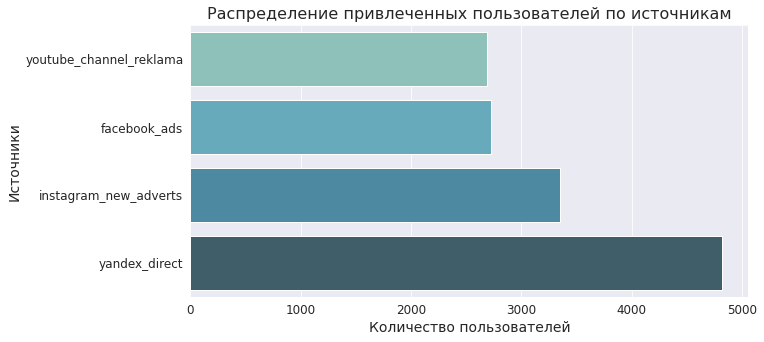

,source,user_id,ratio
3,youtube_channel_reklama,2686,20.0
0,facebook_ads,2726,20.0
1,instagram_new_adverts,3347,25.0
2,yandex_direct,4817,35.0


In [10]:
users_by_sources = sources.groupby('source')['user_id'].count().reset_index().sort_values(by='user_id')
users_by_sources['ratio'] = round(users_by_sources['user_id'] / users_by_sources['user_id'].sum() * 100)

plt.figure(figsize=(10, 5)) # график
ax = sns.barplot(x='user_id', y='source', data=users_by_sources, palette='GnBu_d')
plt.title('Распределение привлеченных пользователей по источникам', fontsize=16)
plt.xlabel('Количество пользователей', fontsize=14)
plt.ylabel('Источники', fontsize=14)
plt.tick_params(labelsize=12)
plt.show()


users_by_sources

Больше всего пользователей приходит из источника `yandex_direct` - 35%, на втором месте `instagram_new_adverts` - 25%.

### Время прохождения уровня

Выясним сколько пользователей переходит на второй уровень. 

Предварительно добавим к таблице `actions` источник из таблицы `sources`, для дальнейшего анализа источников.

In [11]:
actions = actions.merge(sources, left_on='user_id', right_on='user_id') # объединение таблицы

In [12]:
unique_users = actions['user_id'].nunique()
users_fin_level = actions[actions['event'] == 'finished_stage_1']
print('Всего игроков:', unique_users) 
print('Игроков, завершивших первый уровень:', users_fin_level.shape[0])
print('Доля завершивших перевый уровень: {}%'.format(round(users_fin_level.shape[0] / unique_users * 100)))

Всего игроков: 13576
Игроков, завершивших первый уровень: 5817
Доля завершивших перевый уровень: 43%


До второго уровня доходит 5817 игроков, что составляет 43% от общего числа пользователей.

Выясним сколько времени требуется пользователям на завершение первого уровня. 

In [13]:
fin_ids = users_fin_level['user_id']
actions_fin = actions.query("user_id in @fin_ids")
time_to_fin = actions_fin.sort_values(by=['user_id', 'event_datetime']).groupby('user_id')['event_datetime'].first().to_frame().reset_index()
time_to_fin = time_to_fin.merge(
    users_fin_level[['user_id', 'event_datetime', 'source']], left_on='user_id', right_on='user_id')
time_to_fin = time_to_fin.rename(columns = {'event_datetime_x': 'start', 'event_datetime_y': 'end'})
time_to_fin['delta_hours'] = (time_to_fin ['end']- time_to_fin ['start'])\
    .apply(lambda x: round(x.total_seconds() / 3600, 2))
time_to_fin.head()

,user_id,start,end,source,delta_hours
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,instagram_new_adverts,154.65
1,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,2020-05-17 21:47:49,instagram_new_adverts,301.28
2,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,2020-05-16 19:57:40,facebook_ads,306.83
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,2020-05-15 16:02:01,yandex_direct,271.44
4,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,2020-05-16 13:48:39,instagram_new_adverts,145.98


Мы получили список пользователей, завершивших первый уровень и затраченное время в часах. Посмотрим на распределение, построим графики.

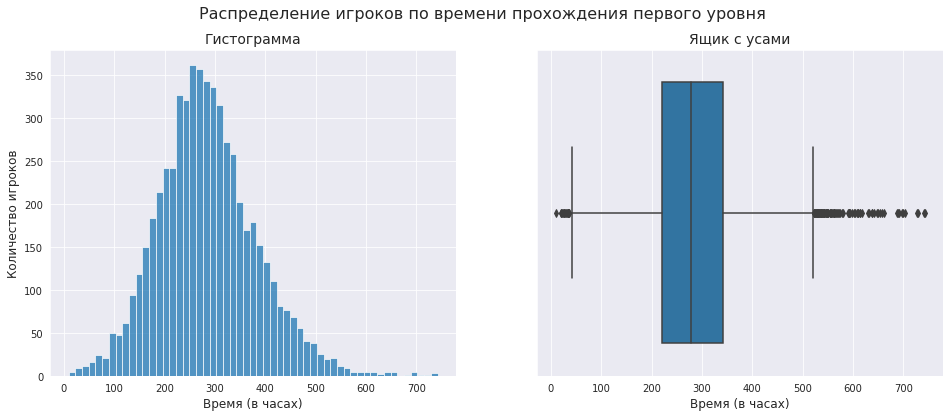

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Распределение игроков по времени прохождения первого уровня', fontsize=16)
sns.histplot(ax=axes[0], data=time_to_fin, x='delta_hours')
axes[0].set_title('Гистограмма', fontsize=14)
axes[0].set_xlabel('Время (в часах)', fontsize=12)
axes[0].set_ylabel('Количество игроков', fontsize=12)

sns.boxplot(x=time_to_fin['delta_hours'])
axes[1].set_title('Ящик с усами', fontsize=14)
axes[1].set_xlabel('Время (в часах)', fontsize=12)
plt.show()

Распределение получилось достаточно симметричным. Большинству пользователей требуется от 100 по 500 часов на прохождение первого уровня.

Выясним, игроки из каких источников быстрее и чаще завершают первый уровень, построим диграммы.

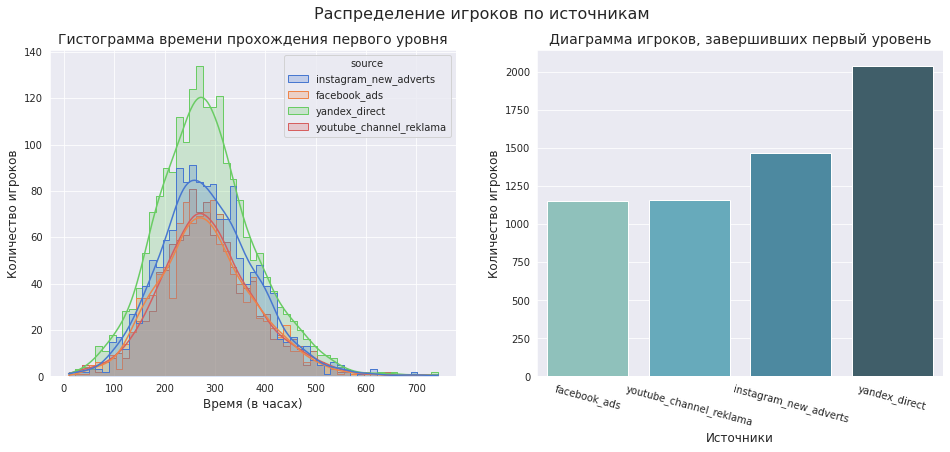

In [15]:
source_fin = users_fin_level.groupby('source')['user_id'].count().reset_index().sort_values(by='user_id')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Распределение игроков по источникам', fontsize=16)
sns.histplot(ax=axes[0], data=time_to_fin, x='delta_hours', hue='source', palette='muted', kde=True, element='step')
axes[0].set_title('Гистограмма времени прохождения первого уровня', fontsize=14)
axes[0].set_xlabel('Время (в часах)', fontsize=12)
axes[0].set_ylabel('Количество игроков', fontsize=12)

sns.barplot(ax=axes[1], data=source_fin, x='source', y='user_id', palette='GnBu_d')
axes[1].set_title('Диаграмма игроков, завершивших первый уровень', fontsize=14)
axes[1].set_xlabel('Источники', fontsize=12)
axes[1].set_ylabel('Количество игроков', fontsize=12)
plt.xticks(rotation=-15)
plt.show()

Время прохождения первого уровня примерно одинаково расределено между игроками из разных источников. Чаще всего уровень завершают игроки из источников `yandex_direct` и `instagram_new_adverts`, что соответствует количеству привлеченных пользователей из источников. Следовательно, пользователи из разных источников заканчивают первый уровень примерно с равной скоростью и частотой.

### Поведение игроков

Рассмотрим игроков, которые по разному завершили первый уровень.

* Победа над первым врагом
* Реализация проекта - разработка орбитальной сборки спутников

Будем рассматривать поведение игроков как **PVP** (Player vs Player) и **PVE** (Player vs Environment) соответственно.

In [16]:
proj = actions_fin[actions_fin['project_type']  == 'satellite_orbital_assembly']
proj_ids = proj['user_id']
pve = actions_fin.query("user_id in @proj_ids")
pvp = actions_fin.query("user_id not in @proj_ids")

print('Игроки завершившие первый уровень:')
print('Стратегия PVE -', pve['user_id'].nunique())
print('Стратегия PVP -', pvp['user_id'].nunique())

Игроки завершившие первый уровень:
Стратегия PVE - 1866
Стратегия PVP - 3951


Стратегии PVE придерживается в 2 раза меньше игроков чем стратегии PVP.

Добавим столбец со стратегией к таблице `time_to_fin` и посмотрим как распределены пользователи по времени прохождения уровня и источнику.

In [17]:
pve_users = pve['user_id'].unique()
pvp_users = pvp['user_id'].unique()

def str_cat(user):
    for i in user:
        if user in pve_users:
            return 'pve'
        if user in pvp_users:
            return 'pvp'
        else:
            return 'not defind'
    
time_to_fin['strategy'] = time_to_fin['user_id'].apply(str_cat)

In [19]:
time_to_fin.head(3)

NameError: name 'source_str' is not defined

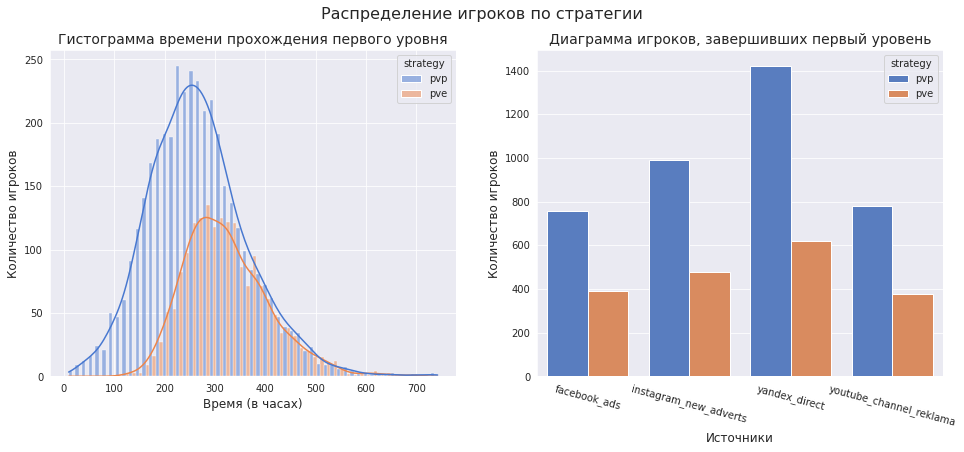

,source,strategy,user_id
0,facebook_ads,pve,391
1,facebook_ads,pvp,759
2,instagram_new_adverts,pve,476
3,instagram_new_adverts,pvp,990
4,yandex_direct,pve,620
5,yandex_direct,pvp,1422
6,youtube_channel_reklama,pve,379
7,youtube_channel_reklama,pvp,780


In [22]:
source_str = time_to_fin.pivot_table(index=['source', 'strategy'], values='user_id', aggfunc='count').reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Распределение игроков по стратегии', fontsize=16)

sns.histplot(ax=axes[0], data=time_to_fin, x='delta_hours', hue='strategy', multiple='dodge', palette='muted', kde=True)
axes[0].set_title('Гистограмма времени прохождения первого уровня', fontsize=14)
axes[0].set_xlabel('Время (в часах)', fontsize=12)
axes[0].set_ylabel('Количество игроков', fontsize=12)

sns.barplot(ax=axes[1], data=source_str, x='source', y='user_id', hue='strategy', palette='muted', hue_order=['pvp', 'pve'])
axes[1].set_title('Диаграмма игроков, завершивших первый уровень', fontsize=14)
axes[1].set_xlabel('Источники', fontsize=12)
axes[1].set_ylabel('Количество игроков', fontsize=12)
plt.xticks(rotation=-15)
plt.show()

time_to_fin.groupby('strategy')['delta_hours'].mean().to_frame()
source_str

На гистограмме видно, что выбирая стратегию PVP, игроки в среднем тратят на часов меньше времени на первый уровень. Источники не влияют на выбор стратегии.

### Постройка зданий

Посмотрим на среднее значение построенных зданий.

In [68]:
buildings = actions_fin.query('event == "building"')
build_by_user = buildings.groupby('user_id')['event'].count().reset_index()
build_by_user['strategy'] = build_by_user['user_id'].apply(str_cat)
print('Среднее построенных игроком зданий:', round(build_by_user['event'].mean()))

Среднее построенных игроком зданий: 10


В среднем игроки строят 10 зданий. Посмотрим на распределение количества построенных игроками зданий в зависимости от источника и стратегии.

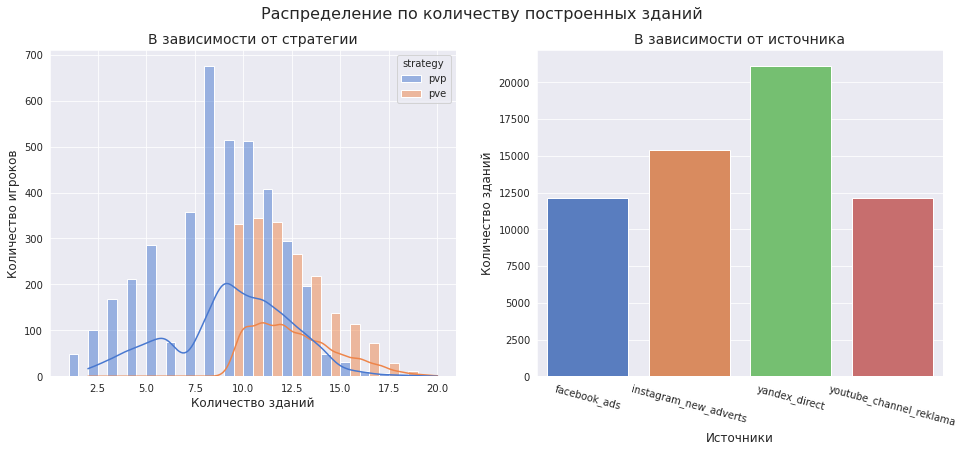

In [69]:
build_by_source = buildings.groupby('source')['event'].count().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Распределение по количеству построенных зданий', fontsize=16)

sns.histplot(ax=axes[0], data=build_by_user, x='event', palette='muted', hue='strategy', multiple='dodge', shrink=3, kde=True)
axes[0].set_title('В зависимости от стратегии', fontsize=14)
axes[0].set_xlabel('Количество зданий', fontsize=12)
axes[0].set_ylabel('Количество игроков', fontsize=12)

sns.barplot(ax=axes[1], data=build_by_source, x='source', y='event', palette='muted')
axes[1].set_title('В зависимости от источника', fontsize=14)
axes[1].set_xlabel('Источники', fontsize=12)
axes[1].set_ylabel('Количество зданий', fontsize=12)
plt.xticks(rotation=-15)
plt.show()

Источник не влияет на количество построенных, так как распределение совпадает с распределением привлеченных пользователей. Игроки со стратегией PVE строят в среднем больше зданий, чем игроки со стратегией PVP. Посмотрим на их средние значения.

In [70]:
print('Среднее количество построенных зданий для стратегии PVP:',
      round(build_by_user.query('strategy == "pvp"')['event'].mean()))
print('Среднее количество построенных зданий для стратегии PVE:',
      round(build_by_user.query('strategy == "pve"')['event'].mean()))

Среднее количество построенных зданий для стратегии PVP: 9
Среднее количество построенных зданий для стратегии PVE: 13


### Вывод

Больше всего пользователей приходит из источника `yandex_direct`. До второго уровня доходит 43% пользователей. Стратегии PVP придерживается примерно в 2 раза больше игроков чем PVE. Выбирая стратегию PVP, игроки быстрее завершают первый уровень. В среднем игроки строят 10 зданий, для стратегии PVE - 13 зданий, для PVP - 9 зданий. Источник не влияет время прохождения уровня и количество построенных зданий.

## Оценка эффективности источников

Оценим эффективность источников. Так как мы определили, что источник не влияет на поведение игроков, на время прохождения первого уровня и количество построенных зданий, то посчитаем стоимость привлечения пользователя для каждого источника.

In [71]:
profiles = actions.sort_values(by=['user_id', 'event_datetime'])\
        .groupby('user_id')\
        .agg({'event_datetime': 'first', 'source': 'first'})\
        .reset_index()
profiles['dt'] = profiles['event_datetime'].dt.date

prof_pivot = profiles.pivot_table(
    index=['dt', 'source'], values='user_id', aggfunc='nunique').sort_values(by=['source', 'dt']).reset_index()
prof_pivot = prof_pivot.drop(columns='source')
prof_pivot = pd.concat([prof_pivot, costs], axis=1)
prof_pivot['user_cost'] = prof_pivot['cost'] / prof_pivot['user_id']

Посчитаем среднюю стоимость пользователя для каждого источника и выведем количество пользователей.

In [72]:
prof_pivot.pivot_table(index='source', values=['user_id', 'user_cost'], aggfunc={'user_id': 'sum', 'user_cost': 'mean'})

,user_cost,user_id
source,,
facebook_ads,0.776358,2726
instagram_new_adverts,0.646144,3347
yandex_direct,0.463491,4817
youtube_channel_reklama,0.403225,2686


Построим график изменения стоимости пользователя по дням для каждого источника.

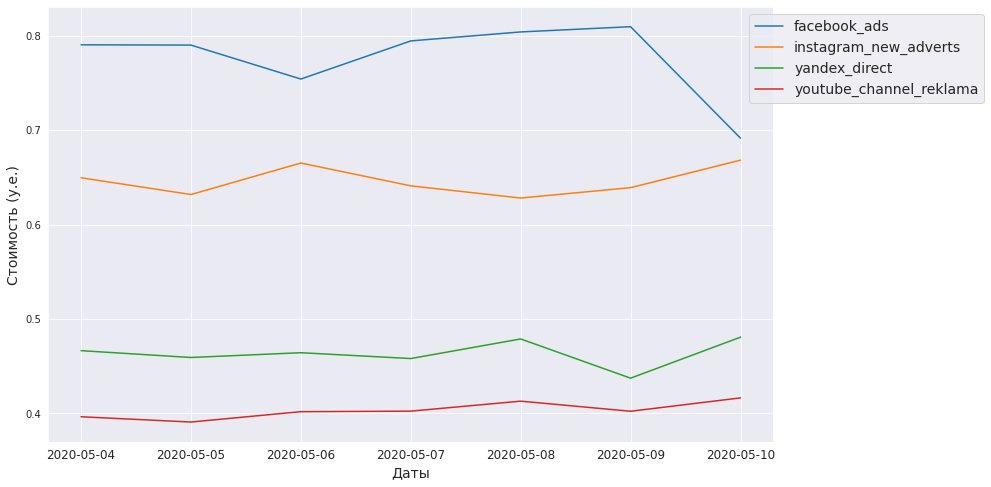

In [101]:
plt.figure(figsize=(13, 8))
sns.lineplot(data=prof_pivot, x='dt', y='user_cost', hue='source')
plt.title('График стоимости привлечения пользователя', fontsize=16)
plt.xlabel('Даты', fontsize=14)
plt.ylabel('Стоимость (у.е.)', fontsize=14)
plt.legend(fontsize = 14, bbox_to_anchor=(1.3, 1))
plt.xticks(fontsize = 12)
plt.show()

### Вывод

Расходы на привлечение пользователей из `facebook` самые высокие, а количество привлеченных пользователей - относительно низкое, определенно это неэффективный источник. `Instagram` привлекает больше пользователей, но их стоимость так же высока. Лучшие значения по количеству пользователей и их стоимости у `yandex`. Самая низкая стоимость у `youtube`, а пользователей почти столько же, как и у `facebook`.

## Статистический анализ данных

Проверим гипотезы с помощью t-test (статистический тест с использованием t-распределения Стьюдента), который позволяет сравнивать средние двух генеральных совокупностей между собой. В нулевой гипотезе мы предпологаем что средние равны. Пороговое значение alpha зададим 0.05.

### Гипотеза 1:

H0. Среднее время завершения уровня не различается в зависимости способа завершения первого уровня;

H1. Среднее время завершения уровня различается в зависимости способа завершения первого уровня.

In [26]:
pvp_time = time_to_fin.query('strategy == "pvp"')
pve_time = time_to_fin.query('strategy == "pve"')

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(pvp_time['delta_hours'], pve_time['delta_hours']) # t-test для двух совокупностей
print('p-значение: ', results.pvalue)

if results.pvalue < alpha: # условия для двух гипотез
    print('Отвергаем нулевую гипотезу о равенстве средних значений времени завершения первого уровня')
else:
    print('Не получилось отвергнуть нулевую гипотезу о равенстве средних значений времени завершения первого уровня')
    
print()
print('Среднее время завершения первого уровня для PVP:', pvp_time['delta_hours'].mean())
print('Среднее время завершения первого уровня для PVE:', pve_time['delta_hours'].mean())

p-значение:  7.256269600176612e-98
Отвергаем нулевую гипотезу о равенстве средних значений времени завершения первого уровня

Среднее время завершения первого уровня для PVP: 266.506671728677
Среднее время завершения первого уровня для PVE: 323.013617363344


### Гипотеза 2

H0. Среднее количество построенных зданий не различается в зависимости способа завершения первого уровня;

H1. Среднее количество построенных зданий различается в зависимости способа завершения первого уровня.

In [27]:
pvp_build = build_by_user.query('strategy == "pvp"')
pve_build = build_by_user.query('strategy == "pve"')

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(pvp_build['event'], pve_build['event']) # t-test для двух совокупностей
print('p-значение: ', results.pvalue)

if results.pvalue < alpha: # условия для двух гипотез
    print('Отвергаем нулевую гипотезу о равенстве количества построенных зданий')
else:
    print('Не получилось отвергнуть нулевую гипотезу о равенстве количества построенных зданий')
    
print()
print('Среднее количество построенных зданий для PVP:', pvp_build['event'].mean())
print('Среднее количество построенных зданий для PVE:', pve_build['event'].mean())

p-значение:  0.0
Отвергаем нулевую гипотезу о равенстве количества построенных зданий

Среднее количество построенных зданий для PVP: 9.411541381928625
Среднее количество построенных зданий для PVE: 12.64790996784566


Мы проверили гипотезы с помощью t-test и можем сделать выводы:

* Среднее время завершения уровня различается в зависимости способа завершения первого уровня
* Среднее количество построенных зданий различается в зависимости способа завершения первого уровня

### Вывод

Среднее время прохождения первого уровня для стратегии PVP меньше, чем для PVE. Также для стратегии PVP можно строить меньше зданий. Вероятно поэтому игроки в 2 раза чаще выбирают стратегию PVP. В игре проблемы с балансом, нужно передать информацию геймдизайнерам.

## Общий вывод

Целью проекта было проанализировать поведение игроков в зависимости от источника перехода.

**По результатам исследования можно сделать  вывод, что поведение игроков не зависит от источника перехода.**

Мы провели исследовательский анализ данных и определи следующее:

* Больше всего пользователей из источника `yandex_direct` - 35% 
* До второго уровня доходит 43% пользователей от их общего числа
* Стратегии PVP придерживается примерно в 2 раза больше игроков чем PVE
* Выбирая стратегию PVP, игроки в среднем тратят на 50 часов меньше времени на первый уровень
* В среднем игроки строят 10 зданий, для стратегии PVE - 13 зданий, для PVP - 9 зданий
* Источник не влияет время прохождения уровня, выбор стратегии и количество построенных зданий

Так как источник не влияет на поведение игроков, то мы посчитали стоимость привлечения пользователя. 

Можно сделать следующие выводы:

* `yandex` самый эффективный источник, лучшие значения по количеству пользователей и их стоимости
* `facebook` неэффективный источник, высокие расходы, относительно низкое число пользователей
* `instagram` привлекает больше пользователей чем `facebook`, но их стоимость так же высока 
* `youtube` - самая низкая стоимость пользователей, а количество почти столько же, как и у `facebook`

Также мы провели статистический анализ данных, проверили гипотезы с помощью t-test и можем сделать выводы:

* Среднее время завершения уровня различается в зависимости способа завершения первого уровня

* Среднее количество построенных зданий различается в зависимости способа завершения первого уровня

Игроки почти в 2 раза чаще выбирают стратегию PVP чем PVE, так как PVP требует меньше времени и меньше зданий для прохождения первого уровня. В игре нарушен баланс.

**Рекомендации для заказчика:**

* Перераспределить рекламный бюджет с канала `facebook` на `yandex` и `youtube`
* Передать информацию геймдизайнерам о проблемах с балансом в игре